## Multi-Class Text Classification Using Machine Learning Algorithms

In [ ]:
# Author : Abir Rahali <abirrahali2016@gmail.com>
# Date   : 13-11-2023


This notebook encompasses a comprehensive workflow that spans essential stages of the data science pipeline. Beginning with meticulous data preparation, the dataset undergoes thorough cleansing, handling missing values, and encoding categorical variables to ensure its readiness for analysis. Subsequently, the notebook seamlessly transitions into the realm of machine learning, where models are trained and fine-tuned with precision. Rigorous testing and evaluation procedures are integrated to validate the model's performance, ensuring robustness and reliability. This holistic approach within the notebook guarantees a robust foundation for deriving meaningful insights and predictions from the data.

In [37]:
print("\nSTEP: Importing packages and loading data")

# Dataframe Packages
import pandas as pd
pd.set_option('display.max_colwidth', None)

import numpy as np
import pickle

# Visalisation Packages
import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline
import seaborn as sns

# Text Processing Packages
import string
import multiprocessing
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Warning
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

# Sklearn Algorithms
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Sklearn Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Sklearn Feature Engineering
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline


# Time
from datetime import datetime 

# Deep Learning
from transformers import AutoTokenizer, TFAutoModel
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [25]:
print("\nSTEP : Define the constants")
TRAIN_DATA_PATH   = "data/medical_tc_train.csv"
TEST_DATA_PATH    = "data/medical_tc_test.csv"

# You should see the data fields before defining the Constants
TEXT_COLUMN_NAME  = "medical_abstract"
LABEL_COLUMN_NAME = "condition_label"
LABELS            = pd.read_csv("data/medical_tc_labels.csv")[LABEL_COLUMN_NAME]


STEP : Define the constants


# I. Dataset preparation

The selected dataset is a specialized medical abstracts dataset tailored for a multi-class classification task. The dataset provides detailed descriptions of medical cases categorized into five distinct classes, each representing a specific patient condition. The classes include "Neoplasms," "Digestive system diseases," "Nervous system diseases," "Cardiovascular diseases," and "General pathological conditions." With a comprehensive breakdown of training and test samples, the dataset facilitates robust model training and evaluation. The class distribution is as follows:

- **Neoplasms**: 2530 training samples, 633 test samples, totaling 3163 instances.
- **Digestive system diseases**: 1195 training samples, 299 test samples, totaling 1494 instances.
- **Nervous system diseases**: 1540 training samples, 385 test samples, totaling 1925 instances.
- **Cardiovascular diseases**: 2441 training samples, 610 test samples, totaling 3051 instances.
- **General pathological conditions**: 3844 training samples, 961 test samples, totaling 4805 instances.

In total, the dataset comprises 11,550 training samples and 2,888 test samples, providing a rich and diverse foundation for developing and assessing text classification models aimed at discerning various medical conditions from abstracts.

In [27]:
print("\nSTEP : Load the data files")

test_df = pd.read_csv(TEST_DATA_PATH)
train_df = pd.read_csv(TRAIN_DATA_PATH)

# Unique labels in data
print("\nINFO : Labels in the dataset")
print("List of labels -> {}".format(train_df[LABEL_COLUMN_NAME].unique()))
print("Number of labels -> {}".format(len(train_df[LABEL_COLUMN_NAME].unique())))

# Shape of data:
print("\nINFO : Shape of datasets")
print("Train -> {}".format(train_df.shape))
print("Test -> {}".format(test_df.shape))

print("\nINFO : Example of data fields")
train_df.head(3)


STEP : Load the data files

INFO : Labels in the dataset
List of labels : [5 1 2 3 4]
Number of labels : 5

INFO : Shape of datasets
Train : (11550, 2)
Test : (2888, 2)

INFO : Example of data fields


,condition_label,medical_abstract
0,5,"Tissue changes around loose prostheses. A canine model to investigate the effects of an antiinflammatory agent. The aseptically loosened prosthesis provided a means for investigating the in vivo and in vitro activity of the cells associated with the loosening process in seven dogs. The cells were isolated and maintained in culture for sufficient periods of time so that their biologic activity could be studied as well as the effect of different agents added to the cells in vivo or in vitro. The biologic response as determined by interleukin-1 and prostaglandin E2 activity paralleled the roentgenographic appearance of loosening and the technetium images and observations made at the time of revision surgery. The correlation between clinical, roentgenographic, histologic, and biochemical loosening indicates that the canine model is suitable for investigating the mechanisms of prosthetic failure. A canine model permits the study of possible nonsurgical therapeutic interventions with the ultimate hope of stopping or slowing the loosening process."
1,1,"Neuropeptide Y and neuron-specific enolase levels in benign and malignant pheochromocytomas. Neuron-specific enolase (NSE) is the isoform of enolase, a glycolytic enzyme found in the neuroendocrine system. Neuropeptide Y (NPY) is a peptide recently discovered in the peripheral and central nervous systems. Serum NSE and plasma NPY levels have been reported to be increased in some patients with pheochromocytoma. The authors evaluated whether the measurement of these molecules could help to discriminate between benign and malignant forms of pheochromocytoma. The NSE levels were normal in all patients with benign pheochromocytoma (n = 13) and elevated in one half of those with malignant pheochromocytoma (n = 13). Plasma NPY levels were on the average significantly higher in the malignant (177.1 +/- 38.9 pmol/l, n = 16) than in the benign forms of the disease (15.7 +/- 389 pmol/l, n = 24). However, there was no difference in the percentage of patients with elevated NPY levels. These results show that determination of serum NSE may be useful for distinguishing between malignant and benign pheochromocytoma; the measurement of plasma NPY is not useful for differentiating the two kinds of tumors."
2,2,"Sexually transmitted diseases of the colon, rectum, and anus. The challenge of the nineties. During the past two decades, an explosive growth in both the prevalence and types of sexually transmitted diseases has occurred. Up to 55 percent of homosexual men with anorectal complaints have gonorrhea; 80 percent of the patients with syphilis are homosexuals. Chlamydia is found in 15 percent of asymptomatic homosexual men, and up to one third of homosexuals have active anorectal herpes simplex virus. In addition, a host of parasites, bacterial, viral, and protozoan are all rampant in the homosexual population. Furthermore, the global epidemic of AIDS has produced a plethora of colorectal manifestations. Acute cytomegalovirus ileocolitis is the most common indication for emergency abdominal surgery in the homosexual AIDS population. Along with cryptosporidia and isospora, the patient may present to the colorectal surgeon with bloody diarrhea and weight loss before the diagnosis of human immunodeficiency virus (HIV) disease. Other patients may present with colorectal Kaposi's sarcoma or anorectal lymphoma, and consequently will be found to have seropositivity for HIV. However, in addition to these protean manifestations, one third of patients with AIDS consult the colorectal surgeon with either condylomata acuminata, anorectal sepsis, or proctitis before the diagnosis of HIV disease. Although aggressive anorectal surgery is associated with reasonable surgical results in some asymptomatic HIV positive patients, the same procedures in AIDS (symptomatic HIV positive) patients will often be met with disastrous results. It is incumbent upon the surgeon, therefore, to r

In [28]:
# Data type change
print("\nSTEP : Make sure the text type is string")
train_df['text'] = train_df[TEXT_COLUMN_NAME].astype(str)
test_df['text'] = test_df[TEXT_COLUMN_NAME].astype(str)

# Remove rows with missing values
print("\nSTEP : Remove missing fields")
train_df.dropna(subset = ['text'], inplace = True)
test_df.dropna(subset = ['text'], inplace = True)


STEP : Make sure the text type is string

STEP : Remove missing fields



STEP : Plot the Category distribution of the datasets (train & test)


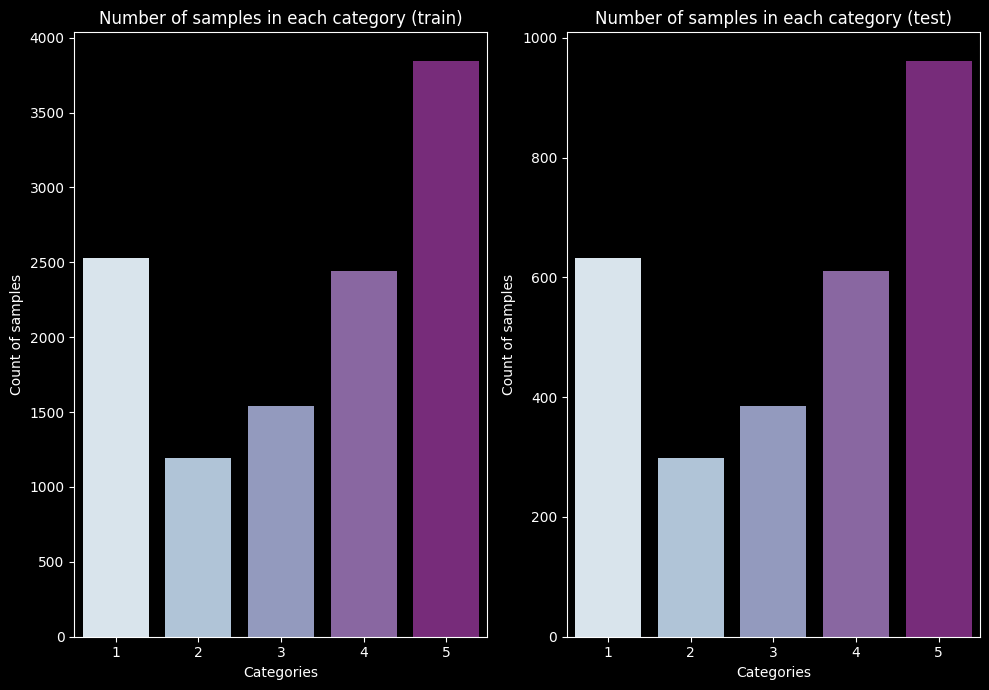

In [29]:
print("\nSTEP : Plot the Category distribution of the datasets (train & test)")

fig, ax = plt.subplots(figsize = (10, 7))
sns.light_palette("seagreen", as_cmap = True)
plt.subplot(1, 2, 1)
sns.countplot(x=LABEL_COLUMN_NAME, data=train_df, palette="BuPu")
plt.ylabel('Count of samples')
plt.xlabel('Categories')
plt.title('Number of samples in each category (train)')


plt.subplot(1, 2, 2)
sns.countplot(x=LABEL_COLUMN_NAME, data=test_df, palette="BuPu")
plt.ylabel('Count of samples')
plt.xlabel('Categories')
plt.title('Number of samples in each category (test)')
fig.tight_layout()

During this crucial pre-processing stage, various tasks are performed to enhance the quality of textual data. Firstly, punctuation, stop words, and undesirable characters are systematically removed. Subsequently, the second step involves transforming all words to lowercase and subjecting them to stemming using the Porter Stemmer from the NLTK package. To achieve this, dedicated functions are employed to clean the text, eliminate stop words, and execute the stemming operation for each line of text. This meticulous approach ensures that the text is refined and ready for further analysis or modeling.

In [33]:
print("\nSTEP : Define simple preprocessing")

stop = stopwords.words('english')
porter = PorterStemmer()

def remove_punctuation(description):
    """The function to remove punctuation"""
    table = str.maketrans('', '', string.punctuation)
    return description.translate(table)

def remove_stopwords(text):
    """The function to removing stopwords"""
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

def stemmer(stem_text):
    """The function to apply stemming"""
    stem_text = [porter.stem(word) for word in stem_text.split()]
    return " ".join(stem_text)

print("\nSTEP : Apply simple preprocessing on train data")
train_df['text'] = train_df['text'].apply(remove_punctuation)
train_df['text'] = train_df['text'].apply(remove_stopwords)
train_df['text'] = train_df['text'].apply(stemmer)
train_df['length'] = train_df['text'].apply(len)

print("\nSTEP : Apply simple preprocessing on test data")
test_df['text'] = test_df['text'].apply(remove_punctuation)
test_df['text'] = test_df['text'].apply(remove_stopwords)
test_df['text'] = test_df['text'].apply(stemmer)
test_df['length'] = test_df['text'].apply(len)

print("\nSTEP : Average sample length of the data fields")
print("Train -> {}".format(train_df['length'].unique().mean()))
print("Test -> {}".format(test_df['length'].unique().mean()))

print("\nINFO : Example of data fields after preprocessing")
train_df.head(3)


STEP : Define simple preprocessing

STEP : Apply simple preprocessing on train data

STEP : Apply simple preprocessing on test data

STEP : Average sample length of the data fields
Train -> 914.4876912840984
Test -> 841.9517543859649

INFO : Example of data fields after preprocessing


,condition_label,medical_abstract,text,length
0,5,"Tissue changes around loose prostheses. A canine model to investigate the effects of an antiinflammatory agent. The aseptically loosened prosthesis provided a means for investigating the in vivo and in vitro activity of the cells associated with the loosening process in seven dogs. The cells were isolated and maintained in culture for sufficient periods of time so that their biologic activity could be studied as well as the effect of different agents added to the cells in vivo or in vitro. The biologic response as determined by interleukin-1 and prostaglandin E2 activity paralleled the roentgenographic appearance of loosening and the technetium images and observations made at the time of revision surgery. The correlation between clinical, roentgenographic, histologic, and biochemical loosening indicates that the canine model is suitable for investigating the mechanisms of prosthetic failure. A canine model permits the study of possible nonsurgical therapeutic interventions with the ultimate hope of stopping or slowing the loosening process.",tissu chang around loo prosth canin model investig effect antiinflammatori agent asept loosen prosthesi provid mean investig vivo vitro activ cell associ loosen process seven dog cell isol maintain cultur suffici period time biolog activ could studi well effect differ agent ad cell vivo vitro biolog respon determin interleukin1 prostaglandin e2 activ parallel roentgenograph appear loosen technetium imag observ made time revi surgeri correl clinic roentgenograph histolog biochem loosen indic canin model suitabl investig mechan prosthet failur canin model permit studi possibl nonsurg therapeut interv ultim hope stop slow loosen process,641
1,1,"Neuropeptide Y and neuron-specific enolase levels in benign and malignant pheochromocytomas. Neuron-specific enolase (NSE) is the isoform of enolase, a glycolytic enzyme found in the neuroendocrine system. Neuropeptide Y (NPY) is a peptide recently discovered in the peripheral and central nervous systems. Serum NSE and plasma NPY levels have been reported to be increased in some patients with pheochromocytoma. The authors evaluated whether the measurement of these molecules could help to discriminate between benign and malignant forms of pheochromocytoma. The NSE levels were normal in all patients with benign pheochromocytoma (n = 13) and elevated in one half of those with malignant pheochromocytoma (n = 13). Plasma NPY levels were on the average significantly higher in the malignant (177.1 +/- 38.9 pmol/l, n = 16) than in the benign forms of the disease (15.7 +/- 389 pmol/l, n = 24). However, there was no difference in the percentage of patients with elevated NPY levels. These results show that determination of serum NSE may be useful for distinguishing between malignant and benign pheochromocytoma; the measurement of plasma NPY is not useful for differentiating the two kinds of tumors.",neuropeptid neuronspecif enola level benign malign pheochromocytoma neuronspecif enola nse isoform enola glycolyt enzym found neuroendocrin system neuropeptid npi peptid recent discov periph central nervou system serum nse plasma npi level report increa patient pheochromocytoma author evalu whether measur molecul could help discrimin benign malign form pheochromocytoma nse level normal patient benign pheochromocytoma n 13 elev one half malign pheochromocytoma n 13 plasma npi level averag significantli higher malign 1771 389 pmoll n 16 benign form disea 157 389 pmoll n 24 howev differ percentag patient elev npi level result show determin serum nse may use distinguish malign benign pheochromocytoma measur plasma npi use differenti two kind tumor,753
2,2,"Sexually transmitted diseases of the colon, rectum, and anus. The challenge of the nineties. During the past two decades, an explosive growth in both the prevalence and types of sexually transmitted diseases has occurred. Up to 55 percent of homosexual men with anorect

# II. Machine Learning

In the realm of Natural Language Processing (NLP), various methods can be employed to apply a model effectively. These encompass diverse techniques such as Count Vectors, TF-IDF Vectors (at word, N-Gram, and Character levels), Word Embeddings, etc. Each method brings unique advantages and is suitable for different applications. However, for the specific task at hand, I have opted to employ TF-IDF (Term Frequency-Inverse Document Frequency) vectors and Word2Vec embeddings as the chosen features to assess machine learning algorithms. TF-IDF provides a numerical representation of the importance of words in a document, capturing their significance across a corpus, while Word2Vec, a form of word embedding, captures semantic relationships between words, enhancing the model's understanding of context and meaning. This strategic combination aims to leverage the strengths of both methods to achieve optimal performance in the chosen machine learning tasks.

#### II. i. Machine Learning (TFIDF)

In [34]:
# Define the 2 parts of the dataset (X, y)

# Train Set
X_train = train_df['text']
y_train = train_df[LABEL_COLUMN_NAME]

# Test Set
X_test = test_df['text']
y_test = test_df[LABEL_COLUMN_NAME]

#The data set is already devided into train and test (no need to validate in ML Algos)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state = 42)

STEP : Train the Model


 ---------------------- Logistic Regression ----------------------- 

RESULT : Average Accuracy (test) for Logistic Regression : 57.2% 
              precision    recall  f1-score   support

           1       0.68      0.72      0.70       633
           2       0.53      0.41      0.46       299
           3       0.53      0.43      0.48       385
           4       0.66      0.67      0.67       610
           5       0.47      0.52      0.49       961

    accuracy                           0.57      2888
   macro avg       0.58      0.55      0.56      2888
weighted avg       0.57      0.57      0.57      2888



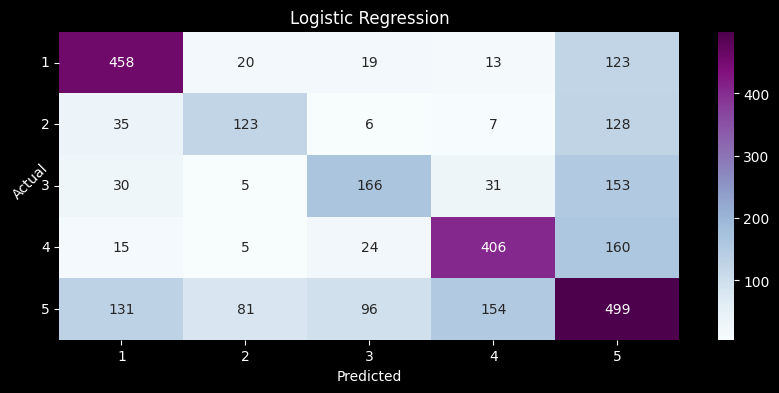

STEP : Save the Model
INFO : Time elapsed to train then test this algorithm (hh:mm:ss) : 0:00:13
STEP : Train the Model


 ---------------------- Linear SVM ----------------------- 

RESULT : Average Accuracy (test) for Linear SVM : 43.7% 
              precision    recall  f1-score   support

           1       0.53      0.64      0.58       633
           2       0.39      0.33      0.36       299
           3       0.33      0.45      0.38       385
           4       0.53      0.38      0.44       610
           5       0.39      0.36      0.38       961

    accuracy                           0.44      2888
   macro avg       0.43      0.43      0.43      2888
weighted avg       0.44      0.44      0.43      2888



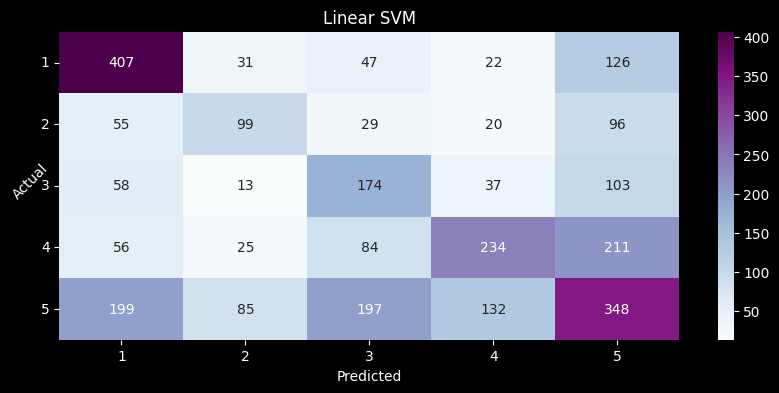

STEP : Save the Model
INFO : Time elapsed to train then test this algorithm (hh:mm:ss) : 0:00:19
STEP : Train the Model


 ---------------------- Decision Tree ----------------------- 

RESULT : Average Accuracy (test) for Decision Tree : 49.5% 
              precision    recall  f1-score   support

           1       0.71      0.58      0.64       633
           2       0.50      0.03      0.05       299
           3       0.00      0.00      0.00       385
           4       0.67      0.52      0.59       610
           5       0.39      0.77      0.52       961

    accuracy                           0.50      2888
   macro avg       0.45      0.38      0.36      2888
weighted avg       0.48      0.50      0.44      2888



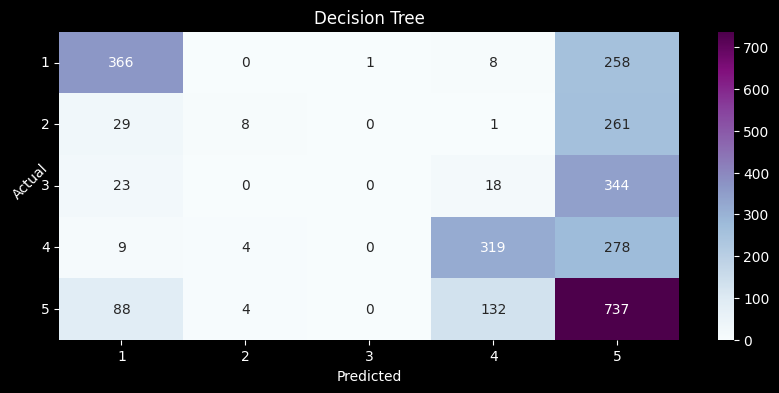

STEP : Save the Model
INFO : Time elapsed to train then test this algorithm (hh:mm:ss) : 0:00:13
STEP : Train the Model


 ---------------------- AdaBoost ----------------------- 

RESULT : Average Accuracy (test) for AdaBoost : 55.6% 
              precision    recall  f1-score   support

           1       0.70      0.72      0.71       633
           2       0.51      0.40      0.45       299
           3       0.53      0.33      0.40       385
           4       0.63      0.66      0.64       610
           5       0.45      0.52      0.48       961

    accuracy                           0.56      2888
   macro avg       0.56      0.53      0.54      2888
weighted avg       0.56      0.56      0.55      2888



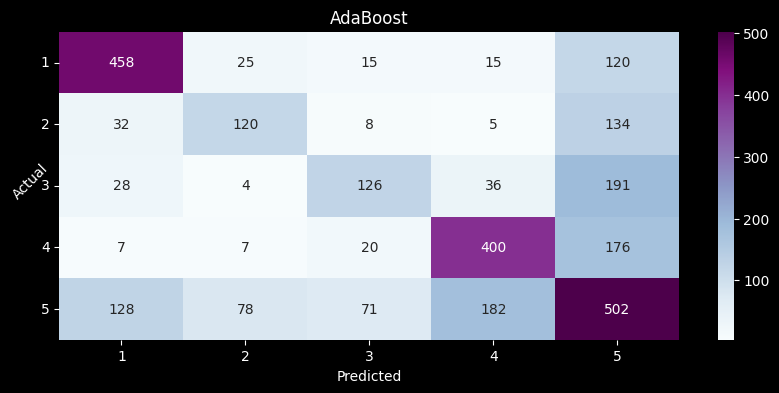

STEP : Save the Model
INFO : Time elapsed to train then test this algorithm (hh:mm:ss) : 0:00:22
STEP : Train the Model


  File "c:\Users\Owner\3D Objects\GLIA\GLIA_NEDICAL\.venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\Owner\AppData\Local\Programs\Python\Python38\lib\subprocess.py", line 493, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\Owner\AppData\Local\Programs\Python\Python38\lib\subprocess.py", line 858, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Owner\AppData\Local\Programs\Python\Python38\lib\subprocess.py", line 1311, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,




 ---------------------- Nearest Neighbors ----------------------- 

RESULT : Average Accuracy (test) for Nearest Neighbors : 49.5% 
              precision    recall  f1-score   support

           1       0.55      0.75      0.63       633
           2       0.42      0.40      0.41       299
           3       0.45      0.37      0.40       385
           4       0.55      0.64      0.59       610
           5       0.43      0.32      0.36       961

    accuracy                           0.49      2888
   macro avg       0.48      0.49      0.48      2888
weighted avg       0.48      0.49      0.48      2888



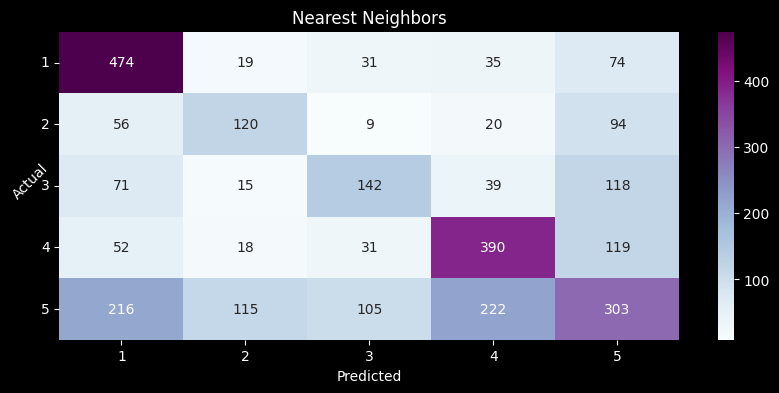

STEP : Save the Model
INFO : Time elapsed to train then test this algorithm (hh:mm:ss) : 0:00:23
STEP : Train the Model


 ---------------------- Neural Net ----------------------- 

RESULT : Average Accuracy (test) for Neural Net : 57.5% 
              precision    recall  f1-score   support

           1       0.72      0.71      0.72       633
           2       0.56      0.21      0.31       299
           3       0.59      0.33      0.42       385
           4       0.68      0.69      0.68       610
           5       0.46      0.63      0.53       961

    accuracy                           0.58      2888
   macro avg       0.60      0.51      0.53      2888
weighted avg       0.59      0.58      0.56      2888



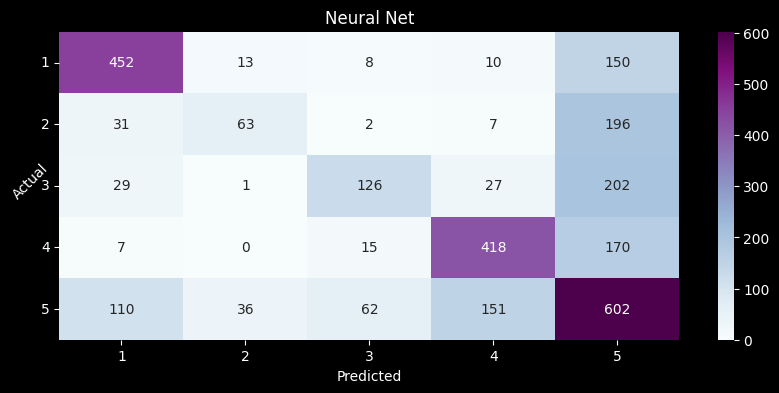

STEP : Save the Model
INFO : Time elapsed to train then test this algorithm (hh:mm:ss) : 0:00:34


In [36]:
# Create different classifiers (the selection of these classifiers to test with is Random from the simpliest to the more complex)
classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=100, random_state=42),
    "LinearSVM": SVC(gamma='auto', kernel='linear', max_iter=100, random_state=42),
    "DecisionTree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "NearestNeighbors": KNeighborsClassifier(5),

    "NeuralNet": MLPClassifier(alpha=1, max_iter=500, random_state=42, activation = 'relu', solver='adam'),
}
n_classifiers = len(classifiers)


# A funtion to plot the results
def plot_results(name, y_test, y_pred, labels):
    print("\n ---------------------- " + name + " ----------------------- \n")
    print("\nRESULT : Average Accuracy (test) for %s : %0.1f%% " % (name, accuracy_score(y_test, y_pred) * 100))
    print(classification_report(y_test, y_pred))

    conf_mat = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize = (10, 4))
    sns.heatmap(conf_mat, annot = True, fmt = 'd', cmap = "BuPu", xticklabels = labels, yticklabels = labels)
    plt.ylabel('Actual', rotation = 45)
    plt.yticks(rotation = 0)
    plt.xlabel('Predicted')
    plt.title(name)
    plt.show()


# Loop through the classifiers
for index, (name, classifier) in enumerate(classifiers.items()):
    # Define the ML Classifier (Model)
    start_time = datetime.now() 
    model = Pipeline([
               # Here where TFIDF is used as feature extraction method
               ('vect', CountVectorizer(min_df = 0.01, max_df = 0.40, ngram_range = (1, 6))), 
               ('tfidf', TfidfTransformer()),
               ('model', classifier),
               ])
    # Fit the ML Classifier (Model)
    print(f"\nSTEP : Train the Model")
    model.fit(X_train, y_train)
    # Predict the test data
    y_pred = model.predict(X_test)
    plot_results(name, y_test, y_pred, LABELS)
    print(f"\nSTEP : Save the Model")
    filename = f'models/Trained_{name}_MedicalDataset_MODEL.sav'
    pickle.dump(model, open(filename, 'wb'))
    time_elapsed = datetime.now() - start_time 
    print('INFO : Time elapsed to train then test this algorithm (hh:mm:ss) : {}'.format(str(time_elapsed).split(".")[0]))

#### II. ii. Machine Learning (Doc2Vec)

In [39]:
print(f"\nSTEP : Train the Doc2Vec model")
start_time = datetime.now() 
cores = multiprocessing.cpu_count()
doc_model = Doc2Vec(dm=0, vector_size=900, negative=5, hs=0, min_count=2, sample = 0, workers=cores)

train_tag = train_df.apply(lambda x: TaggedDocument(words=word_tokenize(x['text']), tags=[x[LABEL_COLUMN_NAME]]), axis=1)
test_tag = test_df.apply(lambda x: TaggedDocument(words=word_tokenize(x['text']), tags=[x[LABEL_COLUMN_NAME]]), axis=1)
               
doc_model.build_vocab(train_tag)
doc_model.train(train_tag, total_examples=doc_model.corpus_count, epochs=30) 

def vector_for_learning(model, input_docs):
    sents = input_docs
    targets, feature_vectors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    return targets, feature_vectors

y_train, X_train = vector_for_learning(doc_model, train_tag)
y_test, X_test = vector_for_learning(doc_model, test_tag)
print('\nINFO : Time elapsed to train doc2vec algorithm (hh:mm:ss) : {}'.format(str(time_elapsed).split(".")[0]))


STEP : Train the Doc2Vec model

INFO : Time elapsed to train doc2vec algorithm (hh:mm:ss) : 0:00:34




 ---------------------- Logistic Regression ----------------------- 

RESULT : Average Accuracy (test) for Logistic Regression : 53.0% 
              precision    recall  f1-score   support

           1       0.64      0.73      0.68       633
           2       0.41      0.39      0.40       299
           3       0.53      0.42      0.47       385
           4       0.61      0.66      0.63       610
           5       0.42      0.40      0.41       961

    accuracy                           0.53      2888
   macro avg       0.52      0.52      0.52      2888
weighted avg       0.52      0.53      0.52      2888



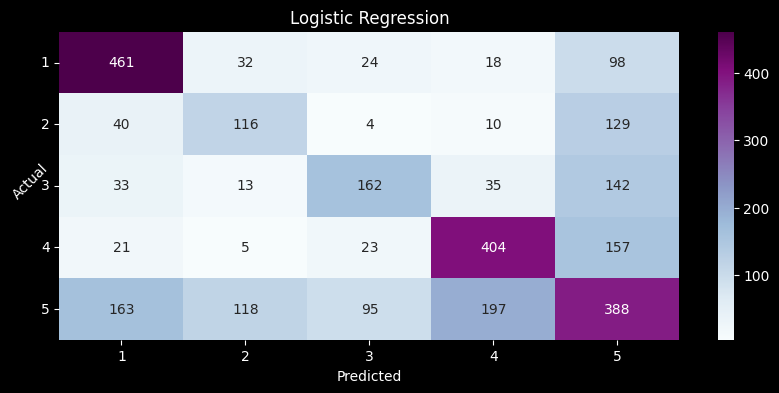

INFO : Time elapsed to train then test this algorithm (hh:mm:ss) : 0:00:03


 ---------------------- Linear SVM ----------------------- 

RESULT : Average Accuracy (test) for Linear SVM : 40.6% 
              precision    recall  f1-score   support

           1       0.42      0.56      0.48       633
           2       0.36      0.45      0.40       299
           3       0.40      0.37      0.38       385
           4       0.48      0.34      0.40       610
           5       0.38      0.35      0.36       961

    accuracy                           0.41      2888
   macro avg       0.41      0.41      0.40      2888
weighted avg       0.41      0.41      0.40      2888



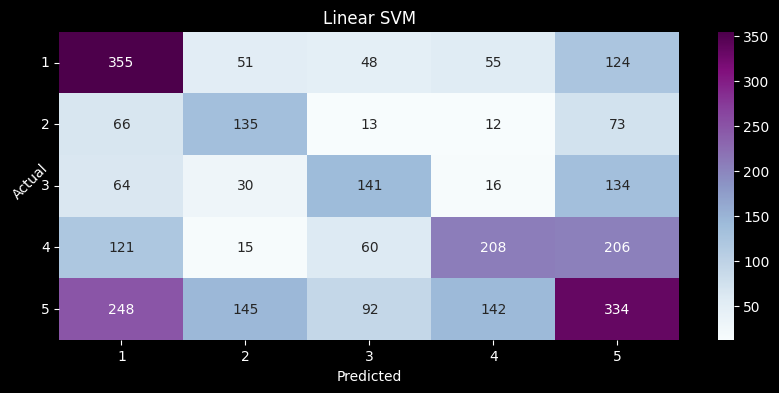

INFO : Time elapsed to train then test this algorithm (hh:mm:ss) : 0:00:06


 ---------------------- Decision Tree ----------------------- 

RESULT : Average Accuracy (test) for Decision Tree : 40.7% 
              precision    recall  f1-score   support

           1       0.50      0.55      0.52       633
           2       0.31      0.16      0.21       299
           3       0.30      0.38      0.34       385
           4       0.50      0.39      0.44       610
           5       0.37      0.41      0.39       961

    accuracy                           0.41      2888
   macro avg       0.40      0.38      0.38      2888
weighted avg       0.41      0.41      0.40      2888



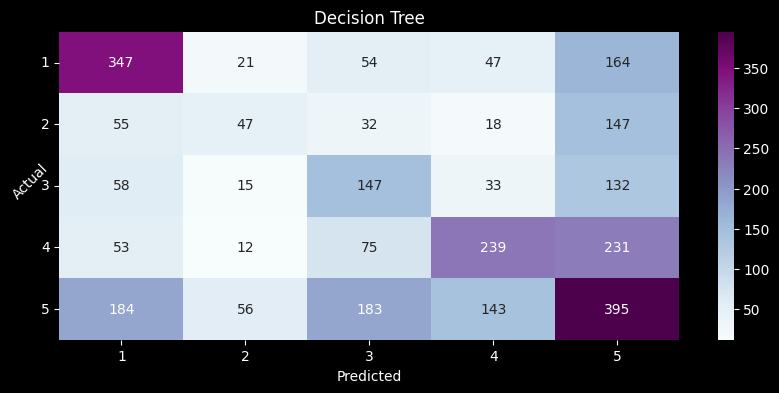

INFO : Time elapsed to train then test this algorithm (hh:mm:ss) : 0:00:13


 ---------------------- AdaBoost ----------------------- 

RESULT : Average Accuracy (test) for AdaBoost : 50.9% 
              precision    recall  f1-score   support

           1       0.62      0.65      0.64       633
           2       0.37      0.40      0.39       299
           3       0.48      0.53      0.51       385
           4       0.57      0.64      0.60       610
           5       0.43      0.35      0.39       961

    accuracy                           0.51      2888
   macro avg       0.50      0.52      0.50      2888
weighted avg       0.50      0.51      0.50      2888



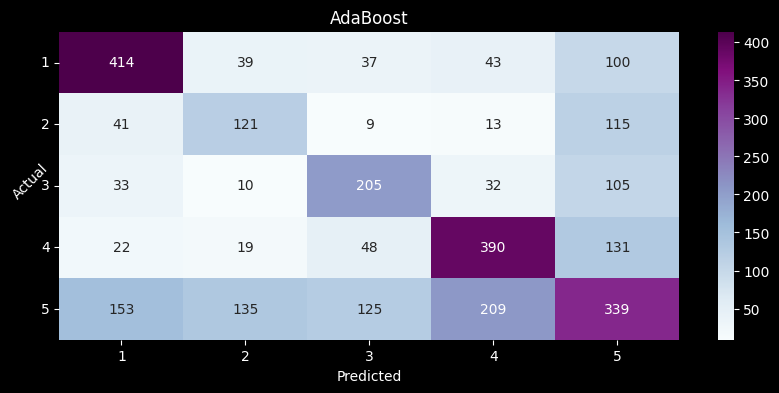

INFO : Time elapsed to train then test this algorithm (hh:mm:ss) : 0:02:49


 ---------------------- Nearest Neighbors ----------------------- 

RESULT : Average Accuracy (test) for Nearest Neighbors : 47.2% 
              precision    recall  f1-score   support

           1       0.53      0.76      0.63       633
           2       0.40      0.37      0.38       299
           3       0.46      0.47      0.46       385
           4       0.55      0.60      0.57       610
           5       0.35      0.24      0.28       961

    accuracy                           0.47      2888
   macro avg       0.46      0.49      0.47      2888
weighted avg       0.45      0.47      0.45      2888



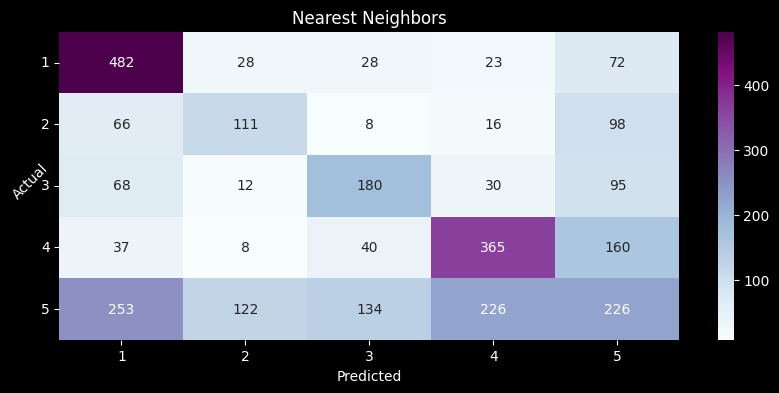

INFO : Time elapsed to train then test this algorithm (hh:mm:ss) : 0:00:00


 ---------------------- Neural Net ----------------------- 

RESULT : Average Accuracy (test) for Neural Net : 51.4% 
              precision    recall  f1-score   support

           1       0.64      0.71      0.67       633
           2       0.41      0.37      0.39       299
           3       0.49      0.47      0.48       385
           4       0.59      0.64      0.61       610
           5       0.40      0.37      0.38       961

    accuracy                           0.51      2888
   macro avg       0.51      0.51      0.51      2888
weighted avg       0.51      0.51      0.51      2888



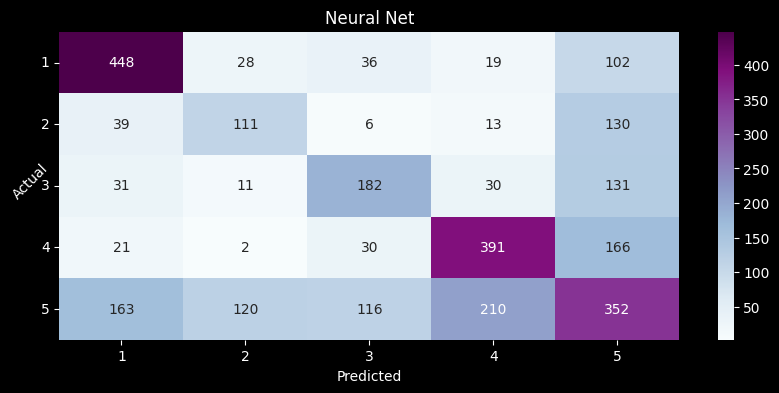

INFO : Time elapsed to train then test this algorithm (hh:mm:ss) : 0:00:18


In [40]:
for index, (name, classifier) in enumerate(classifiers.items()):
    # Define the ML Classifier (Model)
    start_time = datetime.now() 
    model = Pipeline([
               ('model', classifier),
               ])
    # Fit the ML Classifier (Model)
    model.fit(X_train, y_train)
    # Predict the test data
    y_pred = model.predict(X_test)
    plot_results(name, y_test, y_pred, LABELS)
    time_elapsed = datetime.now() - start_time 
    print('INFO : Time elapsed to train then test this algorithm (hh:mm:ss) : {}'.format(str(time_elapsed).split(".")[0]))

# III. Prediction:

In [76]:
print(f"\nSTEP : Prediction Example")

# This is not a true example abstract (Just a text to test the model)
new_abstract = "I think he has Depression, he didn't sleep well lately"

categories_map = {
    1: "Neoplasms",
    2: "Digestive system diseases",
    3: "Nervous system diseases",
    4: "Cardiovascular diseases",
    5: "General pathological conditions",
}

def predict(abstract):
    start_time = datetime.now() 
    model = pickle.load(open('models\Trained_NeuralNet_MedicalDataset_MODEL.sav', 'rb'))
    time_elapsed = datetime.now() - start_time 
    print('\nINFO : Time elapsed to load the model (hh:mm:ss) : {}'.format(str(time_elapsed).split(".")[0]))
    start_time = datetime.now() 
    category_number = model.predict([abstract])
    category_name = categories_map[category_number[0]]
    prediction_proba = "%.2f" % (max(model.predict_proba([abstract])[0])*100) + "%"
    print('\nPrediction Proba -> {}'.format(prediction_proba))
    print('Predicted Class -> {}'.format(category_name))
    time_elapsed = datetime.now() - start_time 
    print('\nINFO : Time elapsed to predict (hh:mm:ss) : {}'.format(str(time_elapsed).split(".")[0]))
    print(f"\n==> Predicted Class :")
    return category_name


print(predict(new_abstract))



STEP : Prediction Example

INFO : Time elapsed to load the model (hh:mm:ss) : 0:00:00

Prediction Proba -> 44.95%
Predicted Class -> General pathological conditions

INFO : Time elapsed to predict (hh:mm:ss) : 0:00:00

==> Predicted Class :
General pathological conditions


## CONCLUSION :

In our quest to improve how accurate our predictions are, I experimented with various machine learning models. I initially thought that using Doc2Vec, a technique known for its advanced understanding of context, would give us better results. However, our tests showed that the current models we were using didn't perform as well in predicting classes. With a more traditional approach using TFIDF vectors, the models actually performed better. Among them, our Neural Network using TFIDF vectors stood out, achieving an accuracy rate of 57.5%. This accuracy is still low and can be improved using other methods.


It is important to note that different ways of representing features and designing models play a crucial role in improving predictions. This ongoing exploration is guiding our efforts to refine and optimize predictive capabilities within this specific task. In next notebooks we explored other feature representation methodologies and model architectures to further enhance the accuracy and reliability of our predictions.

**NOTE:** This model has been saved and is seamlessly integrated into the hosted application. 

**NOTE:** Applying the same preprocessing steps to the prediction data as those used during the training phase is crucial for maintaining consistency and ensuring that the model receives input in the same format it was trained on. The preprocessing steps typically involve tokenization, cleaning, and formatting the input data. If the prediction data undergoes different preprocessing compared to the training data, it can lead to inconsistencies, and the model may struggle to make accurate predictions. 

I didn't include this step in this notebook just for time reasons (comparing with preprocessing vs. without preprocessing), again there are multiple ways and methods to apply in order to improve the accuracy and  if more time invested the better the results are goimg to be.